run this on google collab

In [1]:
# general imports
import yfinance as yf
import pandas as pd

In [2]:
# imports for model
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

## Data


### Loading in Data

In [3]:
# reminder to upload the data file to collab
btc_cmc_data = pd.read_csv("bitcoin_prices_2016010120241121.csv", delimiter=";")
print(btc_cmc_data.columns)

Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'timestamp'],
      dtype='object')


In [4]:
# YFINANCE
# create a ticker object, then get history
btc_tk = yf.Ticker("BTC-USD")
btc_all_data_raw = btc_tk.history(period="max")

btc_f_tk = yf.Ticker("BTC=F")
btc_futures_all_data = btc_f_tk.history(period="max")

vix_tk = yf.Ticker("^VIX")
vix_all_data = vix_tk.history(period="max")

In [ ]:
# Kaggle data
btc_tweets_smallest = pd.read_pickle('btc_tweets_smallest.pkl')
btc_tweets_smallest.head()

FileNotFoundError: [Errno 2] No such file or directory: 'btc_tweets_smallest.pkl'

In [ ]:
# # one time code
# btc_tweets_large = pd.read_csv("Bitcoin_tweets.csv", engine='python')
# btc_tweets_small = btc_tweets_large[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_small.to_pickle('btc_tweets_small.pkl')

# btc_tweets_smallest = pd.read_csv("Bitcoin_tweets_dataset_2.csv", engine='python')
# btc_tweets_smallest = btc_tweets_smallest[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_smallest.to_pickle('btc_tweets_smallest.pkl')

# btc_tweets_smallest.to_pickle('~/btc_tweets_smallest.pkl')

,user_followers,user_verified,date,text,hashtags,source,is_retweet
0,4680.0,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False
1,770.0,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False
2,576.0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False
3,236.0,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False
4,12731.0,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False


In [5]:
# Fear and greed data
mkt_sentiment = pd.read_csv("btc_fearandgreed.csv")
mkt_sentiment.set_index('Date', inplace=True)

In [6]:
mkt_sentiment.tail()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2023-03-27,64.0,Greed,27139.888672,18188895178
2023-03-28,59.0,Greed,27268.130859,17783600385
2023-03-29,57.0,Greed,28348.441406,20684945906
2023-03-30,60.0,Greed,28033.562500,22435349951
2023-03-31,63.0,Greed,28478.484375,19001327598


### Cleaning Data

In [7]:
def clean_data(data, start="2020-01-01", end="2023-03-31"):

    # # set Date to index if not already
    # data.set_index('Date', inplace=True)

    # filter with and start and end
    if start:
        data = data[data.index >= start]
    if end:
        data = data[data.index <= end]

    # check number of NA rows
    print(f"{data.isna().any(axis=1).sum()} / {len(data)} has NA in the row" )

    return data

In [8]:
btc_all_data = clean_data(btc_all_data_raw)
vix_all_data =  clean_data(vix_all_data)
mkt_sentiment =  clean_data(mkt_sentiment)

0 / 1186 has NA in the row
0 / 818 has NA in the row
0 / 1186 has NA in the row


In [ ]:
mkt_sentiment.tail()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2023-03-27,64.0,Greed,27139.888672,18188895178
2023-03-28,59.0,Greed,27268.130859,17783600385
2023-03-29,57.0,Greed,28348.441406,20684945906
2023-03-30,60.0,Greed,28033.562500,22435349951
2023-03-31,63.0,Greed,28478.484375,19001327598


In [ ]:
mkt_sentiment.head()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2020-01-01,37.0,Fear,7200.174316,18565664997
2020-01-02,39.0,Fear,6985.470215,20802083465
2020-01-03,38.0,Fear,7344.884277,28111481032
2020-01-04,38.0,Fear,7410.656738,18444271275
2020-01-05,39.0,Fear,7411.317383,19725074095


In [ ]:
# btc_all_data.to_pickle('btc_all_data_2020.pkl')

### CNN-LSTM Model


#### Setting up data for model inputs
* figure out how to train it on multiple columns?

,open,high,low,close,volume
Date,,,,,
2022-05-23 00:00:00+00:00,30309.396484,30590.585938,28975.560547,29098.910156,31483454557
2022-05-24 00:00:00+00:00,29101.125000,29774.355469,28786.589844,29655.585938,26616506245
2022-05-25 00:00:00+00:00,29653.134766,30157.785156,29384.949219,29562.361328,27525063551
2022-05-26 00:00:00+00:00,29564.777344,29834.160156,28261.906250,29267.224609,36774325352
2022-05-27 00:00:00+00:00,29251.140625,29346.943359,28326.613281,28627.574219,36582005748


In [24]:
import math
from sklearn.preprocessing import MinMaxScaler

# https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

all_data = btc_all_data[["Open", "High", "Low", "Close", "Volume"]] # daily data - date is the index
all_data.columns = all_data.columns.str.lower()

training_col = "close"

# split into training and testing data (no validaiton set)
training_data_len = math.ceil(len(all_data) * .8)
train_data = all_data[:training_data_len].iloc[:, :]
test_data = all_data[training_data_len:].iloc[:, :]


# set up training dataset
dataset_train = train_data[training_col].values
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# set up testing dataset
dataset_test = test_data[training_col].values
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

# normalizing values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
# print(scaled_train[:5])
scaled_test = scaler.fit_transform(dataset_test)
# print(scaled_test[:5])

sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# create sequences and labels for testing data
sequence_length = 30  # number of time steps to look back. ... do these need to be the same length
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

# convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

(949, 1)
(237, 1)
torch.Size([899, 50, 1]) torch.Size([899, 1])
torch.Size([207, 30, 1]) torch.Size([207, 1])


In [25]:
# # Fear & Greed Data Preparation
# fear_greed_df = mkt_sentiment[['Value']]  # Assuming 'value' is the column name

# # Split into training and testing data
# training_data_len_fg = math.ceil(len(fear_greed_df) * 0.8)
# train_data_fg = fear_greed_df[:training_data_len_fg]
# test_data_fg = fear_greed_df[training_data_len_fg:]

# # convert training and testing data to numpy arrays and reshape
# dataset_train_fg = train_data_fg['Value'].values
# dataset_train_fg = np.reshape(dataset_train_fg, (-1, 1))
# dataset_test_fg = test_data_fg['Value'].values
# dataset_test_fg = np.reshape(dataset_test_fg, (-1, 1))

# # normalize
# scaler_fg = MinMaxScaler(feature_range=(0, 1))
# scaled_train_fg = scaler_fg.fit_transform(dataset_train_fg)
# scaled_test_fg = scaler_fg.transform(dataset_test_fg)

# # create sequences for training and testing data
# sequence_length = 50  # Same length as used for the price data
# X_train_fg, y_train_fg = [], []
# for i in range(len(scaled_train_fg) - sequence_length):
#     X_train_fg.append(scaled_train_fg[i:i + sequence_length])
#     y_train_fg.append(scaled_train_fg[i + sequence_length])  # Predicting the value after the sequence
# X_train_fg, y_train_fg = np.array(X_train_fg), np.array(y_train_fg)

# X_test_fg, y_test_fg = [], []
# for i in range(len(scaled_test_fg) - sequence_length):
#     X_test_fg.append(scaled_test_fg[i:i + sequence_length])
#     y_test_fg.append(scaled_test_fg[i + sequence_length])
# X_test_fg, y_test_fg = np.array(X_test_fg), np.array(y_test_fg)

# # Convert data to PyTorch tensors
# X_train_fg = torch.tensor(X_train_fg, dtype=torch.float32)
# y_train_fg = torch.tensor(y_train_fg, dtype=torch.float32)
# X_test_fg = torch.tensor(X_test_fg, dtype=torch.float32)
# y_test_fg = torch.tensor(y_test_fg, dtype=torch.float32)

# # Print shapes to verify
# print("Fear & Greed X_train_fg:", X_train_fg.shape, "y_train_fg:", y_train_fg.shape)
# print("Fear & Greed X_test_fg:", X_test_fg.shape, "y_test_fg:", y_test_fg.shape)


Training dataset time range:

#### Architecture

Follow a CNN-LSTM approach

Model Architecture
  1. CNN
  2. Max pooling
  3. LSTM
  4. Dropout
  5. LSTM
  6. Dropout
  7. Dense
  8. Dense

In [26]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [47]:
import torch
import torch.nn as nn

class BTCPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, dropout_rate=0.2):
        super(BTCPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        # Adjust CNN to handle `n_features` input channels (e.g., 5 for OHLCV data)
        self.c1 = nn.Conv1d(in_channels=n_features, out_channels=n_features, kernel_size=2, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # LSTM layers with `input_size=n_features`
        self.lstm1 = nn.LSTM(
            input_size=n_features,  # Match number of features in each time step
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(
            input_size=n_hidden,  # Output from LSTM 1 feeds to LSTM 2
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout2 = nn.Dropout(dropout_rate)

        # Final linear layers
        self.linear1 = nn.Linear(in_features=n_hidden, out_features=1)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=1)

    def forward(self, sequences):
        # Expecting `sequences` to be (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = sequences.size()

        # Permute to match Conv1D expected input: (batch_size, n_features, seq_len)
        x = sequences.permute(0, 2, 1)
        x = self.c1(x)  # Apply Conv1D; shape becomes (batch_size, n_features, new_seq_len)
        x = self.maxpool(x)  # Apply MaxPool; shape becomes (batch_size, n_features, pooled_seq_len)

        # Permute to match LSTM expected input: (pooled_seq_len, batch_size, n_features)
        x = x.permute(2, 0, 1)

        # Initialize hidden state with dynamic batch size
        device = x.device
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device),
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        )

        # Pass through LSTM layers
        lstm_out1, _ = self.lstm1(x, hidden)
        lstm_out1 = self.dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # Use the last time step's output for prediction
        last_time_step = lstm_out2[-1, :, :]

        # Linear layers for final prediction
        y_pred1 = self.linear1(last_time_step)
        # y_pred2 = self.linear2(last_time_step)

        # # # Combine predictions
        # y_pred = y_pred1 + y_pred2

        y_pred = y_pred1

        return y_pred


In [48]:
# Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 24  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 80  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cuda
Epoch [10/80] - Training Loss: 0.0088, Test Loss: 0.0290
Epoch [20/80] - Training Loss: 0.0036, Test Loss: 0.0138
Epoch [30/80] - Training Loss: 0.0034, Test Loss: 0.0087
Epoch [40/80] - Training Loss: 0.0020, Test Loss: 0.0064
Epoch [50/80] - Training Loss: 0.0019, Test Loss: 0.0059
Epoch [60/80] - Training Loss: 0.0016, Test Loss: 0.0058
Epoch [70/80] - Training Loss: 0.0019, Test Loss: 0.0062
Epoch [80/80] - Training Loss: 0.0022, Test Loss: 0.0060


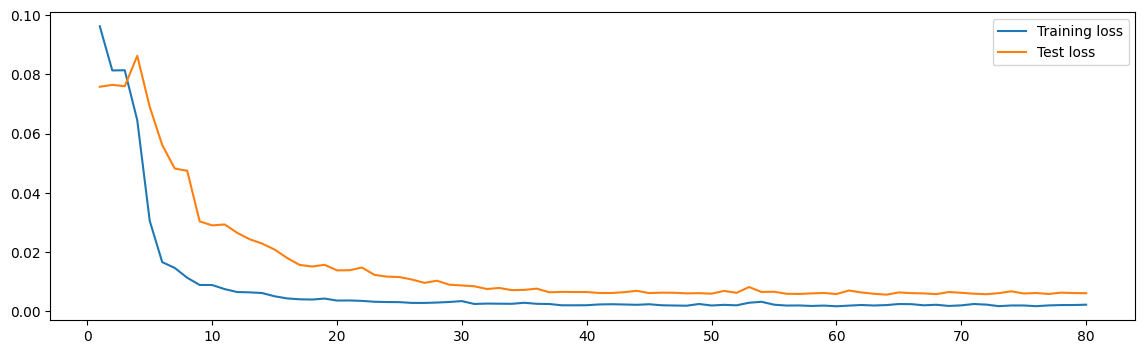

In [49]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

2023-04-01


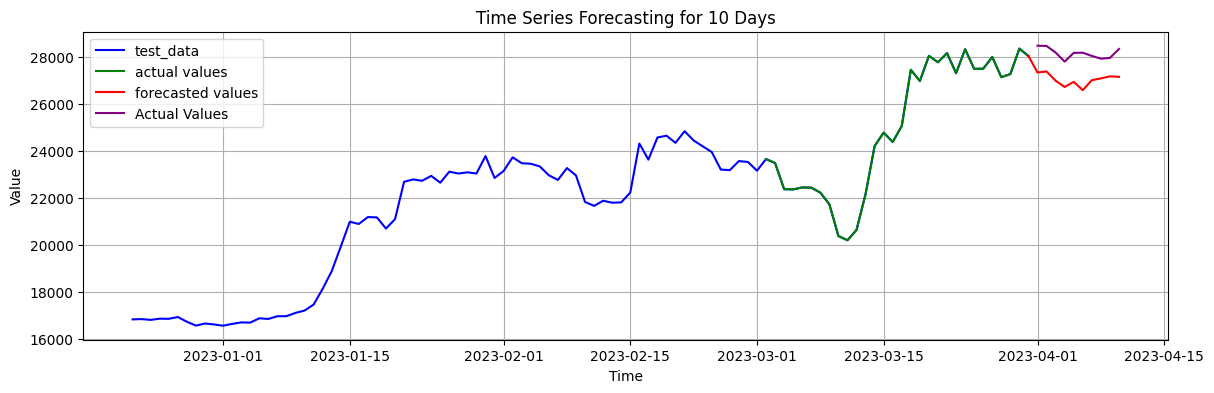

RMSE: 0.0769
R² Score: 0.9089


In [51]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction period in days (can also be set to weeks or months by changing the frequency)
prediction_period = 10  # Specify the number of days, e.g., 60 days for two months
num_forecast_steps = prediction_period

# Prepare historical data for prediction
sequence_to_plot = X_test.squeeze().cpu().numpy() # uses testing dataset?
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare historical data as input to the model
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Convert the last date in the test dataset to datetime format
last_unix_timestamp = test_data.index[-1]
last_date = pd.to_datetime(last_unix_timestamp, unit='s')

# Generate future dates based on the specified prediction period and daily frequency
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=num_forecast_steps, freq='D')

# Plot the historical and forecasted values
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(pd.to_datetime(test_data.index[-100:], unit='s'), test_data['open'].values[-100:], label="test_data", color="b")
plt.plot(pd.to_datetime(test_data.index[-30:], unit='s'), test_data['open'].values[-30:], label='actual values', color='green')

# Concatenate forecasted values and plot
forecasted_series = np.concatenate([test_data["open"].values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])
plt.plot(pd.to_datetime(test_data.index[-1:], unit='s').append(future_dates), forecasted_series, label='forecasted values', color='red')

predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Value': forecasted_series[:-1],
})

# add the actual?
start_pred_date = str(future_dates[0].date())
end_pred_date = str(future_dates[len(future_dates)-1].date())
print(start_pred_date)
sample_period = btc_all_data_raw[(btc_all_data_raw.index >= start_pred_date) & (btc_all_data_raw.index <= end_pred_date)]
plt.plot(sample_period.index, sample_period["Open"].values, label='Actual Values', color='purple')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title(f'Time Series Forecasting for {prediction_period} Days')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)


print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


In [ ]:
predicted_df

,Date,Value
0,2023-04-01 00:00:00+00:00,28032.261719
1,2023-04-02 00:00:00+00:00,26655.876953
2,2023-04-03 00:00:00+00:00,26632.093750
3,2023-04-04 00:00:00+00:00,26877.849609
4,2023-04-05 00:00:00+00:00,26962.496094
5,2023-04-06 00:00:00+00:00,26020.402344
6,2023-04-07 00:00:00+00:00,26326.931641
7,2023-04-08 00:00:00+00:00,26674.373047
8,2023-04-09 00:00:00+00:00,26455.527344
9,2023-04-10 00:00:00+00:00,26625.703125


In [ ]:
sample_period = btc_all_data[(btc_all_data.index >= '2023-04-01') & (btc_all_data.index <= '2023-05-01')]
sample_period.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-01 00:00:00+00:00,28473.332031,28802.457031,28297.171875,28411.035156,10876469901,0.0,0.0
2023-04-02 00:00:00+00:00,28462.845703,28518.958984,27884.087891,28199.308594,12284641999,0.0,0.0
2023-04-03 00:00:00+00:00,28183.080078,28475.623047,27276.720703,27790.220703,19556501327,0.0,0.0
2023-04-04 00:00:00+00:00,27795.273438,28433.742188,27681.304688,28168.089844,15284538859,0.0,0.0
2023-04-05 00:00:00+00:00,28169.726562,28739.238281,27843.763672,28177.984375,17052315986,0.0,0.0


In [ ]:
predicted_df.head()

,Date,Value
0,2023-04-01 00:00:00+00:00,28032.261719
1,2023-04-02 00:00:00+00:00,26998.556641
2,2023-04-03 00:00:00+00:00,26482.806641
3,2023-04-04 00:00:00+00:00,26927.183594
4,2023-04-05 00:00:00+00:00,26135.988281


<Axes: xlabel='Date'>

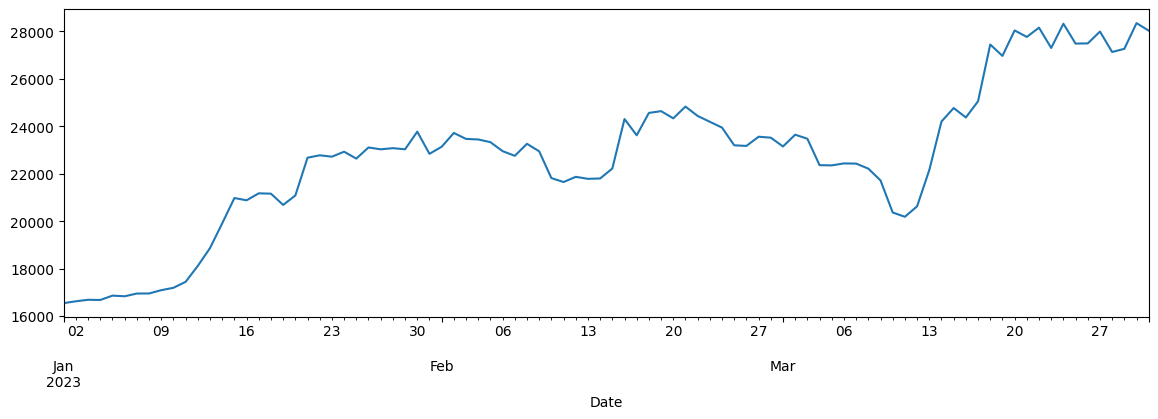

In [ ]:
# Filter the data between 2021-09-01 and 2023-02-01
btc_all_data_filtered = btc_all_data[(btc_all_data.index >= '2023-01-01') & (btc_all_data.index <= '2023-05-01')]
btc_all_data_filtered["Open"].plot()


In [ ]:
len(forecasted_series)
len(future_dates)
forecasted_series

array([28032.26171875, 23577.31445312, 28574.48632812, 27746.59765625,
       26429.48828125, 27811.625     , 27624.421875  , 26283.53125   ,
       26203.96289062, 26208.453125  , 25765.46289062, 24070.74023438,
       23786.453125  , 23866.69921875, 23168.81054688, 21477.64453125,
       21257.9765625 , 21448.37890625, 20714.7890625 , 19302.70117188,
       19321.51171875, 19429.38476562, 18735.73046875, 17716.08984375,
       17738.33398438, 17694.8046875 , 17092.11328125, 16393.84375   ,
       16303.74511719, 16134.55664062, 15633.48730469])

<Axes: xlabel='Date'>

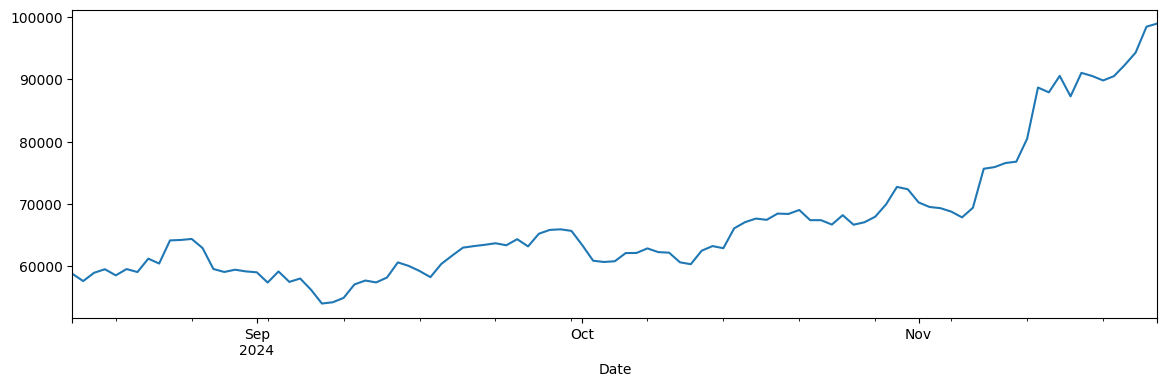

In [ ]:
btc_all_data_filtered = btc_all_data[btc_all_data.index >= '2024-08-15']
# Plot the "Open" column starting from 2024-08-01
btc_all_data_filtered["Open"].plot()

In [52]:
torch.save(model.state_dict(), "./model_daily_close2.pt")

### Backtesting

In [53]:
# load in a model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load("model_daily_close2.pt", weights_only=True, map_location=torch.device('cpu')))
model.eval()

BTCPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(1, 128, num_layers=3)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, num_layers=3)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=128, out_features=1, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [54]:
# using the loaded data, predict

# prior_data is some tensor type ... pass X_test for nows
def predict_prices(prior_data, prediction_period=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_forecast_steps = prediction_period

    # prepare historical data for prediction
    sequence_to_plot = prior_data.squeeze().cpu().numpy() # uses testing dataset?
    historical_data = sequence_to_plot[-1]

    forecasted_values = []
    with torch.no_grad():
        for _ in range(num_forecast_steps):
            # Prepare historical data as input to the model
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
            predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
            forecasted_values.append(predicted_value)

            # Shift historical data for the next prediction
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value

    # unix to datetime
    last_unix_timestamp = test_data.index[-1]
    last_date = pd.to_datetime(last_unix_timestamp, unit='s')
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=num_forecast_steps, freq='D')
    forecasted_series = np.concatenate([test_data["open"].values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])

    predicted_df = pd.DataFrame({
        'Date': future_dates,
        'Value': forecasted_series[:-1],
    })

    return predicted_df



<Axes: >

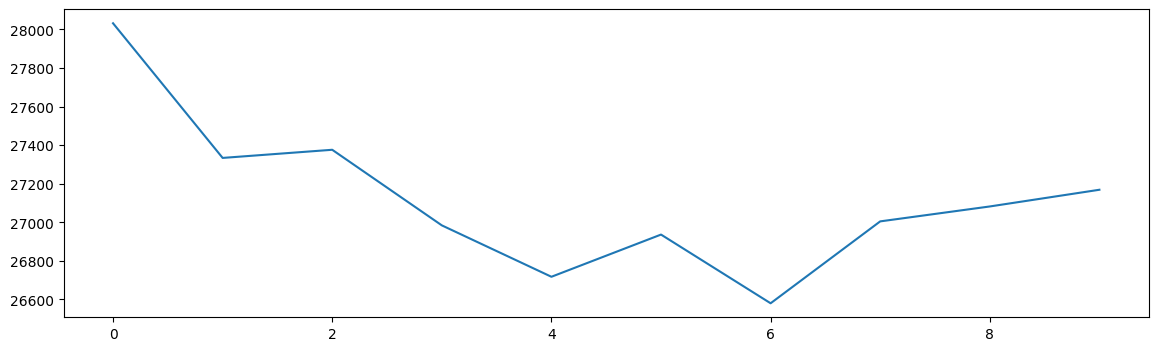

In [55]:
predicted_prices = predict_prices(X_test)
predicted_prices["Value"].plot()

2023-04-01


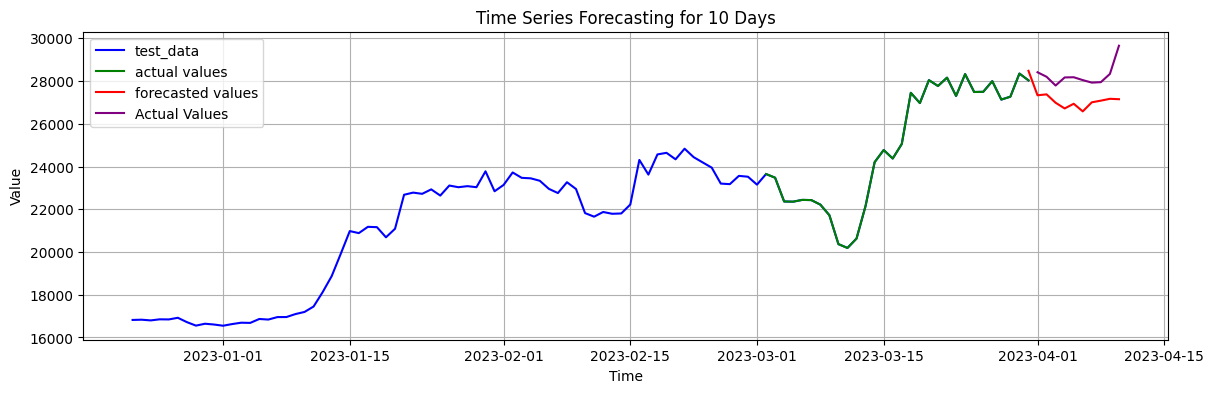

RMSE: 0.0769
R² Score: 0.9089


In [63]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction period in days (can also be set to weeks or months by changing the frequency)
prediction_period = 10  # would want this to be hours
num_forecast_steps = prediction_period

# Prepare historical data for prediction
sequence_to_plot = X_test.squeeze().cpu().numpy() # uses testing dataset?
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare historical data as input to the model
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Convert the last date in the test dataset to datetime format
last_unix_timestamp = test_data.index[-1]
last_date = pd.to_datetime(last_unix_timestamp, unit='s')

# Generate future dates based on the specified prediction period and daily frequency
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=num_forecast_steps, freq='D')

# Plot the historical and forecasted values
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(pd.to_datetime(test_data.index[-100:], unit='s'), test_data['open'].values[-100:], label="test_data", color="b")
plt.plot(pd.to_datetime(test_data.index[-30:], unit='s'), test_data['open'].values[-30:], label='actual values', color='green')

# Concatenate forecasted values and plot
forecasted_series = np.concatenate([test_data["close"].values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])
plt.plot(pd.to_datetime(test_data.index[-1:], unit='s').append(future_dates), forecasted_series, label='forecasted values', color='red')

predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Value': forecasted_series[:-1],
})


# add the actual?
start_pred_date = str(future_dates[0].date())
end_pred_date = str(future_dates[len(future_dates)-1].date())
print(start_pred_date)
sample_period = btc_all_data_raw[(btc_all_data_raw.index >= start_pred_date) & (btc_all_data_raw.index <= end_pred_date)]
plt.plot(sample_period.index, sample_period["Close"].values, label='Actual Values', color='purple')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title(f'Time Series Forecasting for {prediction_period} Days')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)


print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


In [64]:
import numpy as np
import pandas as pd

# Function to determine the trade indices based on predicted values
def determine_trade(predicted, x=10, fee_rate=0.0002):
    """
    Determines trade indices based on predicted data.
    x: x day interval for trading - we assume one transaction
    minimum should be 2 days as price predictions are on a daily basis

    """
    transaction_fees = fee_rate

    # Find minimum of the values, short before that day, then buy in, and sell once it reaches highest
    prices = predicted["Value"]

    # Find minimum of the values
    min_index = np.argmin(prices)
    max_after_min = np.argmax(prices[min_index:]) + min_index  # max after min index

    # Find the maximum price before the minimum price
    if min_index > 0:
        max_before_min = np.argmax(prices[:min_index])  # max before min index
    else:
        max_before_min = -1

    return max_before_min, min_index, max_after_min


# Function to calculate returns based on actual data, using trade indices determined from predicted data
def trade_and_compute_return(predicted, trade_indices,x=10, fee_rate=0.0002):
    max_before_min, min_idx, max_after_min = trade_indices
    long_return = 0
    short_return = 0

    # Get start and end dates for the prediction interval
    start_day = predicted["Date"].iloc[0]
    end_day = predicted["Date"].iloc[x-1]
    print(f"Trading period: {start_day} to {end_day}")

    # Extract actual prices from btc_all_data_raw based on the predicted date range
    relevant_data = btc_all_data_raw[(btc_all_data_raw.index >= start_day) & (btc_all_data_raw.index <= end_day)]
    relevant_prices = relevant_data["Close"].values
    print("Actual prices in interval:", relevant_prices)

    min_price = relevant_prices[min_idx]

    # Short return
    if max_before_min > -1 and max_before_min < len(relevant_prices):
        max_price_before_min = relevant_prices[max_before_min]
        short_return = (max_price_before_min - min_price) / max_price_before_min
        print(f"Short return: {short_return * 100:.2f}%")

    # Long return
    if max_after_min < len(relevant_prices):
        max_price_after_min = relevant_prices[max_after_min]
        long_return = (max_price_after_min - min_price) / min_price
        print(f"Long return: {long_return * 100:.2f}%")

    # Calculate final return by applying fees
    total_return = max(short_return , 0) + max(long_return, 0)
    return total_return



In [65]:
predicted_prices = predict_prices(X_test)

In [66]:
predicted_prices["Value"]

,Value
0,28032.261719
1,27333.869141
2,27376.105469
3,26984.019531
4,26717.351562
5,26936.251953
6,26579.888672
7,27004.707031
8,27082.080078
9,27168.740234


In [67]:
indices = determine_trade(predicted_prices) # return for a 10 interval period
print(indices)
trade_and_compute_return(predicted_prices, indices)

(0, 6, 9)
Trading period: 2023-04-01 00:00:00+00:00 to 2023-04-10 00:00:00+00:00
Actual prices in interval: [28411.03515625 28199.30859375 27790.22070312 28168.08984375
 28177.984375   28044.140625   27925.859375   27947.79492188
 28333.05078125 29652.98046875]
Short return: 1.71%
Long return: 6.18%


0.07892367749439762

In [ ]:
# maybe.. try just making a decision on the interval?